# Workflow

In [1]:
import numpy as np
import sys

sys.path.append('../hydra_tod/')

# Import the FlickerCorrEmulator class first
from flicker_model import FlickerCorrEmulator

In [2]:
# Load the simulation results
import pickle
from simulation import TODSimulation

with open('tod_simulation_single.pkl', 'rb') as f:
    tod_sim = pickle.load(f)


In [3]:
sky_params = tod_sim.sky_params
nd_rec_params = tod_sim.nd_rec_params
gain_params_setting = tod_sim.gain_params_setting
calibration_indices = tod_sim.calibration_5_indices
alpha = tod_sim.alpha

TOD_setting = tod_sim.TOD_setting
t_list = tod_sim.t_list
gain_proj = tod_sim.gain_proj
Tsky_operator_setting = tod_sim.Tsky_operator_setting
nd_rec_operator = tod_sim.nd_rec_operator

logfc = tod_sim.logfc

# Additional variables needed for the analysis
pixel_indices = tod_sim.pixel_indices
nside = tod_sim.nside
f0 = tod_sim.f0
T_ndiode = tod_sim.T_ndiode
rec_params = tod_sim.rec_params
logf0 = tod_sim.logf0  # Convert to list format as expected later

In [4]:
# init_Tsys_params = np.hstack([sky_params, nd_rec_params])
init_noise_params_list = [[logf0, alpha]]
init_Tloc_params_list = [nd_rec_params]
init_Tsky_params = sky_params


prior_std_frac = 0.1

gain_prior_mean = gain_params_setting
gain_prior_cov_inv = 1.0 / (prior_std_frac * gain_params_setting)**2  # Prior STD ~10%
gain_prior_cov_inv[gain_prior_cov_inv > 100] = 100
# gain_prior_cov_inv[0] = 2.51 # DC mode: Prior STD ~10%

Tsky_prior_cov_inv = 1.0 / (prior_std_frac * sky_params)**2
Tsky_prior_cov_inv[calibration_indices] = 1e20

aux = 1.0 / (nd_rec_params)**2  # Prior STD ~100%
aux[0] = 10.0
aux[1] = 1.0

Trec_prior_cov_inv_list = [aux] # Effectively no prior

def log_prior_noise(params):
    _, alpha_est = params
    return -1e10 * (alpha_est - alpha)**4 


In [ ]:
# Import the FlickerCorrEmulator class first
from full_Gibbs_sampler import TOD_Gibbs_sampler

Tsys_samples, all_gain_samples, all_noise_samples= \
    TOD_Gibbs_sampler(
        [TOD_setting],
        [t_list],
        [gain_proj],
        [Tsky_operator_setting],
        [nd_rec_operator],
        init_Tsky_params,
        init_Tloc_params_list,
        init_noise_params_list,
        [logfc],
        wnoise_var=2.5e-6,
        Tsky_prior_cov_inv=Tsky_prior_cov_inv,
        Tsky_prior_mean=sky_params,
        local_Tloc_prior_cov_inv_list=Trec_prior_cov_inv_list,
        local_Tloc_prior_mean_list=[nd_rec_params],
        local_gain_prior_cov_inv_list=[gain_prior_cov_inv],
        local_gain_prior_mean_list=[gain_prior_mean],
        local_noise_prior_func_list=[log_prior_noise],
        joint_Tsys_sampling=True,
        smooth_gain_model="linear",
        noise_sampler_type="emcee",
        noise_Jeffreys_prior=False,
        n_samples=2000,
        tol=1e-20,
        debug=True,)

In [ ]:
np.save("outputs/GSF5/Tsys_samples_linearG.npy", Tsys_samples)
np.save("outputs/GSF5/gain_samples_linearG.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GSF5/noise_samples_linearG.npy", np.concatenate(all_noise_samples, axis=0))


In [5]:
param_names_compact = [
    r'$p_{{\rm g},0}$', r'$p_{{\rm g},1}$', r'$p_{{\rm g},2}$', r'$p_{{\rm g},3}$',  # 4 gain parameters
    r'$p_{{\rm loc},0}$', r'$p_{{\rm loc},1}$', r'$p_{{\rm loc},2}$', r'$p_{{\rm loc},3}$', r'$p_{{\rm loc},4}$',  # 5 receiver parameters
    r'$\log_{10} f_0$', r'$\alpha$'  # 2 noise parameters
]

In [6]:
Tsys_samples = np.load("outputs/GSF5/Tsys_samples_linearG.npy")
gain_samples = np.load("outputs/GSF5/gain_samples_linearG.npy")
noise_samples = np.load("outputs/GSF5/noise_samples_linearG.npy")

### a. Trace plots

In [6]:
from MCMC_diagnostics import diagnostics

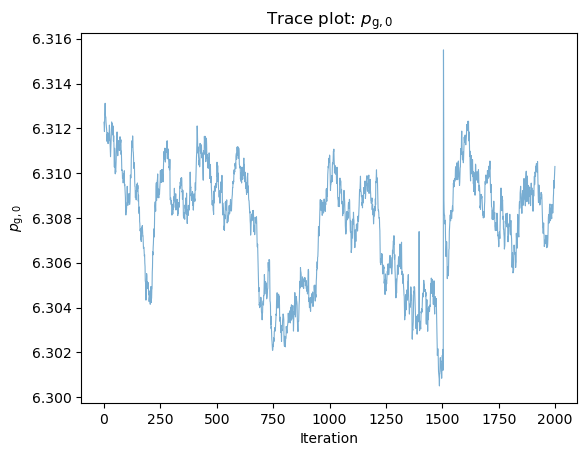

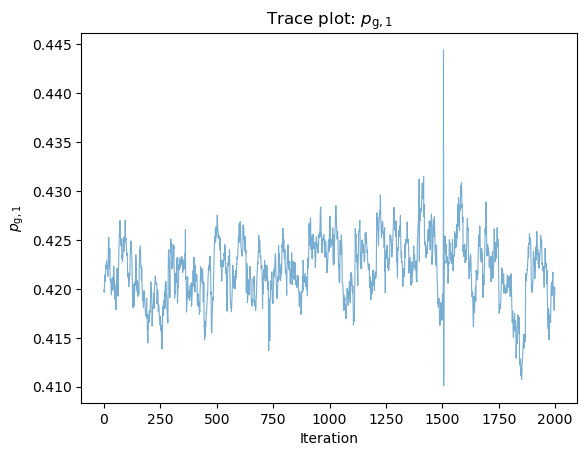

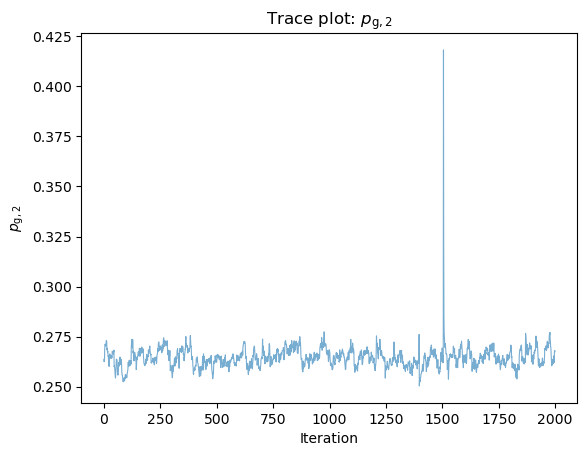

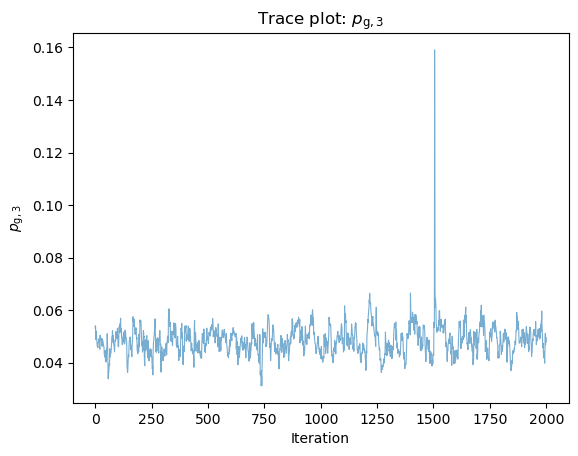

{'$p_{{\\rm g},0}$': {'ESS_min': 14.135086680784923,
  'ESS_median': 14.135086680784923,
  'Rhat_split': 1.003417423571446},
 '$p_{{\\rm g},1}$': {'ESS_min': 27.538588791549003,
  'ESS_median': 27.538588791549003,
  'Rhat_split': 1.0287203275206853},
 '$p_{{\\rm g},2}$': {'ESS_min': 188.0869740766045,
  'ESS_median': 188.0869740766045,
  'Rhat_split': 0.9995434031308013},
 '$p_{{\\rm g},3}$': {'ESS_min': 170.29036129701646,
  'ESS_median': 170.29036129701646,
  'Rhat_split': 1.006523975861966}}

In [8]:
diagnostics(gain_samples, param_names=param_names_compact[:4], max_plots=5)

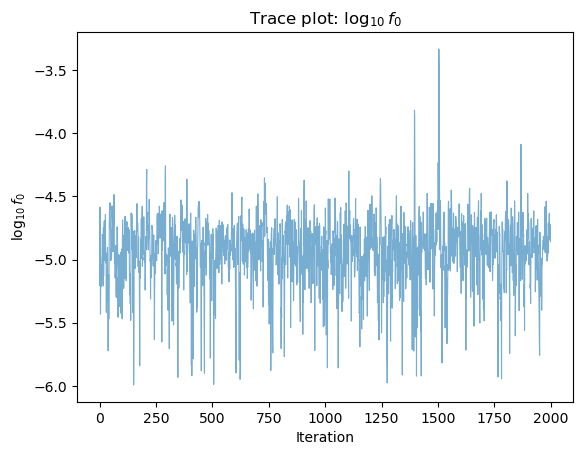

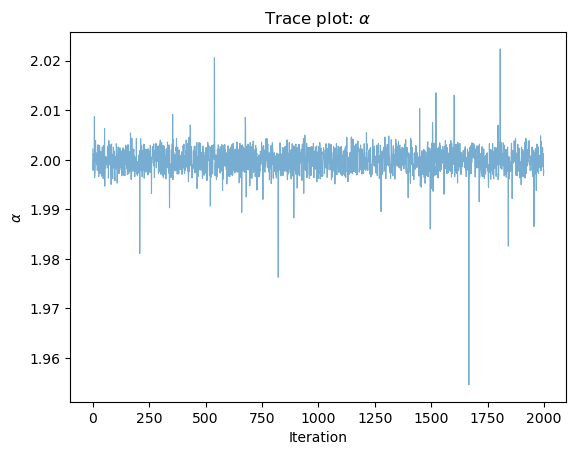

{'$\\log_{10} f_0$': {'ESS_min': 632.1107227508396,
  'ESS_median': 632.1107227508396,
  'Rhat_split': 0.9999064712204684},
 '$\\alpha$': {'ESS_min': 1846.095908493101,
  'ESS_median': 1846.095908493101,
  'Rhat_split': 0.9995557379806163}}

In [9]:
diagnostics(noise_samples, param_names=param_names_compact[9:], max_plots=5)

In [7]:
from visualisation import plot_residual_histogram, view_patch_map, gnomview_patch
from analysis import explore_posterior_joint_Tsys

292


All pixels - Mean: 0.0054, Std: 0.1502, RMS: 0.1503
All pixels - 16th-84th percentile: [-0.0561, 0.1013]
Internal pixels - Mean: 0.0056, Std: 0.1384, RMS: 0.1385
Internal pixels - 16th-84th percentile: [-0.0485, 0.0871]
Plot saved to: figures/new/GSF5_mean_res.pdf


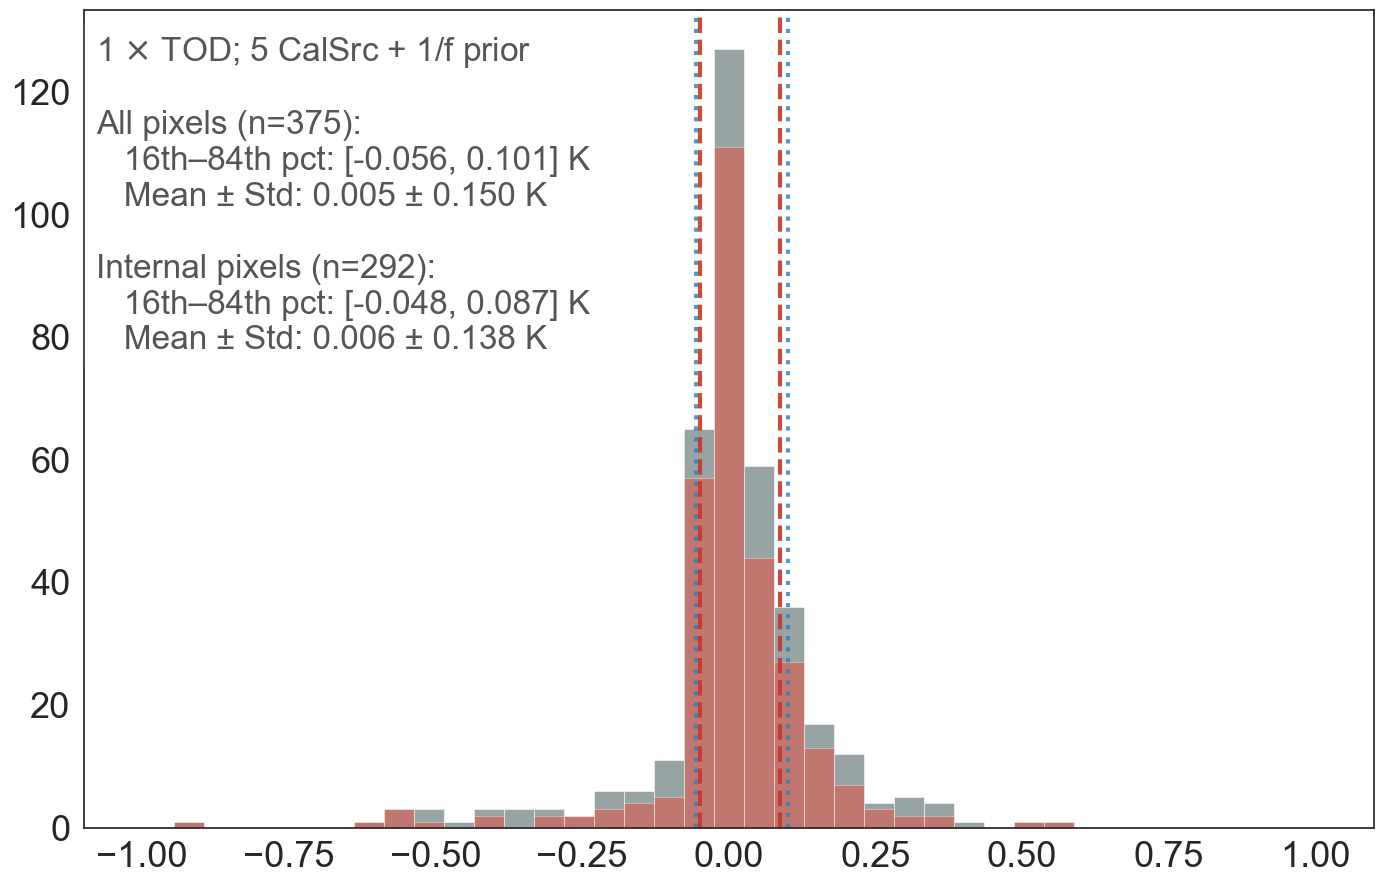

All pixels - Mean: 0.0057, Std: 0.1512, RMS: 0.1513
All pixels - 16th-84th percentile: [-0.0570, 0.0996]
Internal pixels - Mean: 0.0059, Std: 0.1397, RMS: 0.1398
Internal pixels - 16th-84th percentile: [-0.0482, 0.0875]
Plot saved to: figures/new/GSF5_median_res.pdf


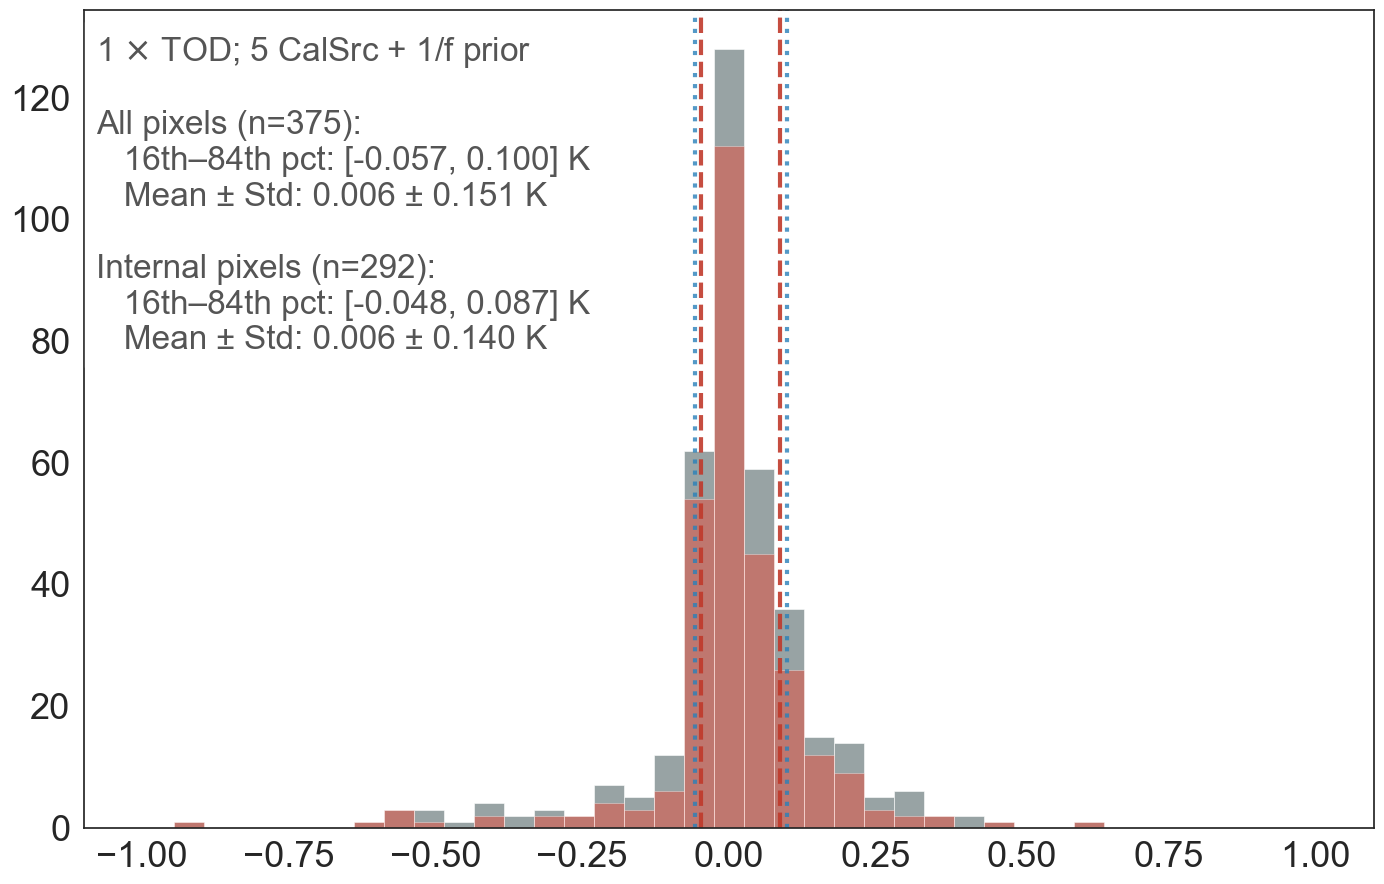

/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be in

{'mean': (array([ 7.85555516,  8.11352612,  7.7428161 ,  7.53022365,  8.43078194,
          7.36360349,  6.89099799,  6.91703461,  6.83179936,  7.0317726 ,
          6.28411426,  6.36196825,  5.80516561,  5.85280004,  5.43887669,
          5.16678968,  5.54106326,  5.75146541,  5.69535765,  7.87022297,
          8.01038174,  8.2503097 ,  8.41681991,  8.07859262,  7.59693747,
          7.00480199,  6.23699762,  7.02532855,  6.77898931,  6.49319086,
          6.60558111,  5.89400757,  6.03223041,  5.54202838,  5.60123565,
          5.22136559,  5.66884014,  6.11352411,  5.90473941,  8.07907611,
         11.01892617,  8.04708208,  7.86532645,  8.13094204,  7.61352871,
          7.81649066,  7.02377453,  6.85299276,  7.17253409,  7.03629306,
          6.50532174,  6.08264653,  5.93240515,  5.88314751,  6.0865519 ,
          6.02308331,  5.73125863,  5.81699767,  5.98924611,  8.27740729,
          8.09787631,  8.37667621,  8.08078279,  8.33632474,  8.14584517,
          7.50046782,  7.30188

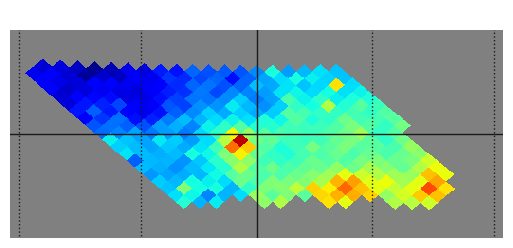

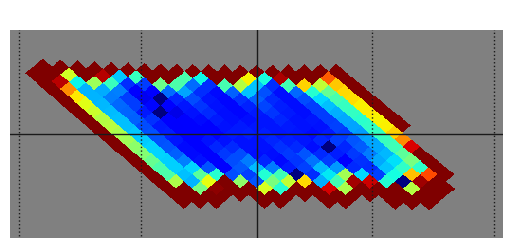

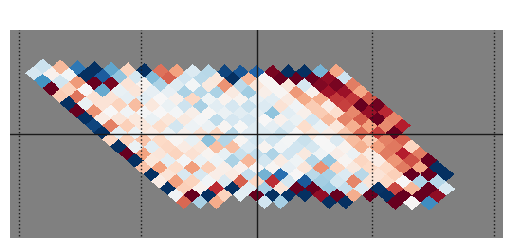

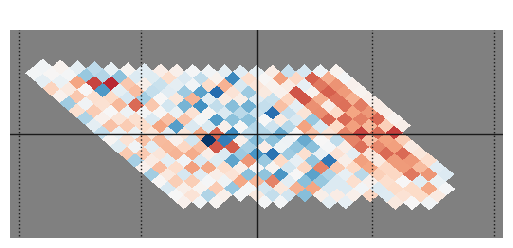

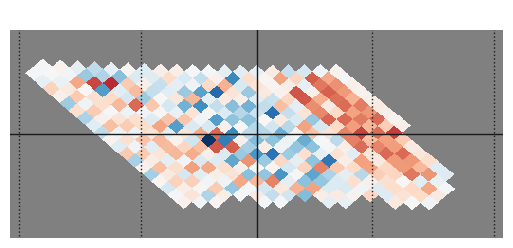

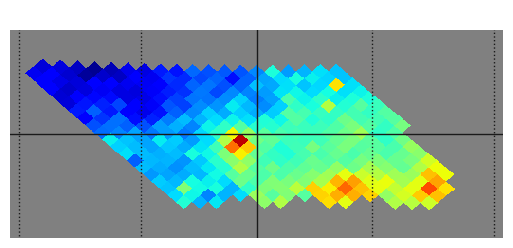

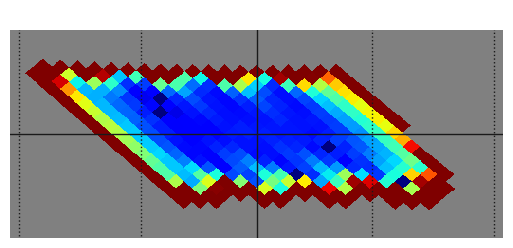

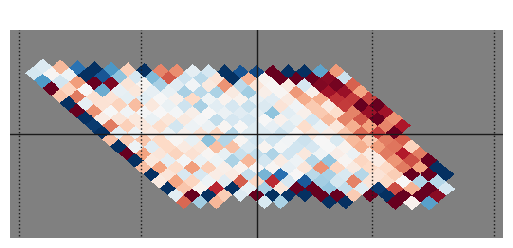

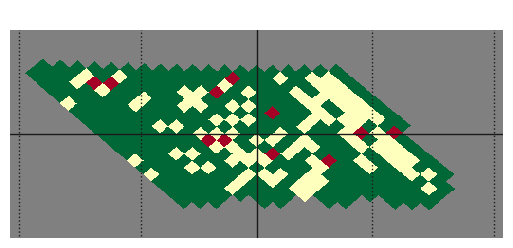

In [8]:
explore_posterior_joint_Tsys(Tsys_samples, 
                             gain_samples, 
                             noise_samples, 
                             sky_params,
                             title_str= r'1 $\times$ TOD; 5 CalSrc + 1/f prior',
                             save_path='figures/new/GSF5',
                             two_x_TODs=False, 
                             warm_up=0, 
                             cbar=False
                             )
